# Metabolomic Analysis for Cytochrome b Inhibitor Identification

## Overview

This notebook reproduces the metabolomic analysis described in:

**"Untargeted metabolomics for triaging of cytochrome b inhibitors during Chagas' disease drug discovery"**

### Background

During phenotypic screening for Chagas' disease drug discovery, approximately 20% of hits act through cytochrome b, a promiscuous target. This analysis demonstrates how untargeted metabolomic profiling can reliably identify and triage these compounds early in the drug discovery workflow.

### Methodology

The workflow includes:
1. Loading LC-MS peak area data from T. cruzi epimastigotes
2. Data preprocessing (log transformation)
3. Quantile normalization to reduce technical variation
4. Principal component analysis (PCA) to separate compound classes
5. Loading analysis to identify key metabolic features

This analysis reproduces **Figure 3** from the manuscript, validating the cytochrome b metabolomic signature.

## 0. Set Random Seeds for Reproducibility

To ensure reproducibility of all stochastic processes (e.g., PCA initialization, dimensionality reduction algorithms like t-SNE and UMAP), we set random seeds for all relevant libraries.

In [1]:
import random
import numpy as np

# Set random seeds
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"✓ Random seeds set to {RANDOM_SEED} for reproducibility")

✓ Random seeds set to 42 for reproducibility


## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ProjectUtility import dim_red_utility
from ProjectUtility.core import convert_palette_to_hex, create_group_color_mapping

# Set plotting style
plt.style.use('ggplot')

## 2. Load and Prepare Peak Area Data

### Data Description

The input data contains LC-MS peak areas for metabolites identified in T. cruzi epimastigotes following treatment with various compounds:
- **Cytochrome b inhibitors**: Known inhibitors of the Qi active site
- **Non-cytochrome b inhibitors**: Compounds acting through other targets (CYP51, NMT, PTR, etc.)
- **Other OxPhos inhibitors**: Compounds disrupting oxidative phosphorylation through other mechanisms
- **QC samples**: Quality control pooled samples
- **Solvent blank**: Negative control

Each metabolite is annotated with:
- Chemical formula
- Metabolite name (if identified)
- Mass accuracy (delta mass in ppm)
- m/z and retention time

In [3]:
# Load peak area data
df = pd.read_csv('Peak areas.csv')

# Create unique identifier for each metabolite feature
# Format: Formula_Name_DeltaMass
df['index'] = df['Formula'].str.replace(' ','').astype(str) + '_' + \
              df['Name'].astype(str) + '_' + \
              df['Annot. DeltaMass [ppm]'].astype(str)

print(f"Loaded data shape: {df.shape}")
df.head()

Loaded data shape: (47, 58)


,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],Sample_2.raw (F4),Sample_6.raw (F8),Sample_7.raw (F9),Sample_12.raw (F15),...,Sample_14a.raw (F46),Sample_16a.raw (F48),Sample_18a.raw (F51),Sample_19a.raw (F52),Sample_20a.raw (F53),Sample_8.raw (F10),Sample_13.raw (F16),Sample_8a.raw (F39),Sample_13a.raw (F45),index
0,Isovalerylcarnitine,C12 H23 N O4,0.26,245.16277,246.17005,3.490,5.118391e+08,5.419645e+08,6.695055e+08,9.070443e+08,...,22911066.86,3.697091e+07,25059736.41,2.943277e+07,34533998.82,3.918035e+07,6.348154e+07,1.645082e+07,47510046.38,C12H23NO4_Isovalerylcarnitine_0.26
1,Phenylalanine,C9 H11 N O2,0.50,165.07906,166.08634,4.013,2.792202e+08,2.812728e+08,2.594075e+08,2.717674e+08,...,93402332.91,1.111985e+08,96582329.58,1.326147e+08,97283486.83,1.277075e+08,1.746037e+08,9.903284e+07,84819761.19,C9H11NO2_Phenylalanine_0.5
2,Creatinine,C4 H7 N3 O,-1.64,113.05873,114.06600,2.705,1.105390e+08,1.320892e+08,1.030299e+08,9.634633e+07,...,84219269.69,8.371297e+07,84099350.36,1.159518e+08,80384708.00,1.311176e+08,5.206864e+07,1.117317e+08,52285191.68,C4H7N3O_Creatinine_-1.64
3,D-(-)-Alanine,C3 H7 N O2,-1.99,89.04750,90.05478,5.289,8.737665e+07,7.876144e+07,8.595425e+07,9.394967e+07,...,19459905.86,2.017196e+07,28050087.24,2.933373e+07,30071981.13,4.406625e+07,1.173264e+08,2.796933e+07,56727003.20,C3H7NO2_D-(-)-Alanine_-1.99
4,Biotin,C10 H16 N2 O3 S,0.17,244.08820,245.09548,1.211,5.073397e+07,4.627686e+07,4.293289e+07,4.469386e+07,...,25949146.35,1.860639e+07,23436272.94,3.892672e+07,25566403.48,2.151312e+07,3.447886e+07,2.807806e+07,23332732.01,C10H16N2O3S_Biotin_0.17


## 3. Data Cleanup

Remove problematic metabolite features that were identified during quality control.

In [4]:
# Check for gamma-Glutamylalanine (if present)
if 'gamma-Glutamylalanine' in df['Name'].values:
    print("Found gamma-Glutamylalanine at index:", df[df['Name']=='gamma-Glutamylalanine'].index[0])

# Remove problematic feature at index 45
df = df.drop(45)
df = df.reset_index(drop=True)

print(f"Final data shape after cleanup: {df.shape}")

Found gamma-Glutamylalanine at index: 27
Final data shape after cleanup: (46, 58)


## 4. Extract Peak Area Matrix

Select only the sample columns (peak areas) and set metabolite identifiers as row index.
The dataset contains duplicate biological replicates (a and b) for each sample.

In [5]:
# Extract peak area data (all columns from position 7 onwards)
selection = df.set_index('index').iloc[:,7:]

print(f"Peak area matrix shape: {selection.shape}")
print(f"Number of metabolites: {selection.shape[0]}")
print(f"Number of samples: {selection.shape[1]}")
print(f"\nSample columns include: {selection.columns[:5].tolist()} ...")

selection.head()

Peak area matrix shape: (46, 50)
Number of metabolites: 46
Number of samples: 50

Sample columns include: ['Sample_6.raw (F8)', 'Sample_7.raw (F9)', 'Sample_12.raw (F15)', 'Sample_15.raw (F18)', 'Sample_17.raw (F21)'] ...


,Sample_6.raw (F8),Sample_7.raw (F9),Sample_12.raw (F15),Sample_15.raw (F18),Sample_17.raw (F21),Sample_2a.raw (F33),Sample_6a.raw (F37),Sample_7a.raw (F38),Sample_12a.raw (F44),Sample_15a.raw (F47),...,Sample_11a.raw (F43),Sample_14a.raw (F46),Sample_16a.raw (F48),Sample_18a.raw (F51),Sample_19a.raw (F52),Sample_20a.raw (F53),Sample_8.raw (F10),Sample_13.raw (F16),Sample_8a.raw (F39),Sample_13a.raw (F45)
index,,,,,,,,,,,,,,,,,,,,,
C12H23NO4_Isovalerylcarnitine_0.26,5.419645e+08,6.695055e+08,9.070443e+08,4.625111e+08,5.684665e+08,1.766677e+08,1.770912e+08,2.359176e+08,2.265437e+08,2.819941e+08,...,3.880257e+07,22911066.86,3.697091e+07,25059736.41,2.943277e+07,34533998.82,3.918035e+07,6.348154e+07,1.645082e+07,47510046.38
C9H11NO2_Phenylalanine_0.5,2.812728e+08,2.594075e+08,2.717674e+08,2.755865e+08,2.073515e+08,5.915831e+07,7.884840e+07,1.700720e+08,8.907352e+07,1.243781e+08,...,1.072008e+08,93402332.91,1.111985e+08,96582329.58,1.326147e+08,97283486.83,1.277075e+08,1.746037e+08,9.903284e+07,84819761.19
C4H7N3O_Creatinine_-1.64,1.320892e+08,1.030299e+08,9.634633e+07,1.250872e+08,6.697208e+07,2.734699e+07,4.250530e+07,1.325695e+08,4.469304e+07,6.294323e+07,...,8.510393e+07,84219269.69,8.371297e+07,84099350.36,1.159518e+08,80384708.00,1.311176e+08,5.206864e+07,1.117317e+08,52285191.68
C3H7NO2_D-(-)-Alanine_-1.99,7.876144e+07,8.595425e+07,9.394967e+07,7.321021e+07,7.130992e+07,2.500834e+07,2.945397e+07,4.175380e+07,3.706628e+07,4.913464e+07,...,1.870180e+07,19459905.86,2.017196e+07,28050087.24,2.933373e+07,30071981.13,4.406625e+07,1.173264e+08,2.796933e+07,56727003.20
C10H16N2O3S_Biotin_0.17,4.627686e+07,4.293289e+07,4.469386e+07,3.031389e+07,4.048891e+07,1.203074e+07,1.612548e+07,3.803387e+07,2.192118e+07,1.939596e+07,...,2.698666e+07,25949146.35,1.860639e+07,23436272.94,3.892672e+07,25566403.48,2.151312e+07,3.447886e+07,2.807806e+07,23332732.01


## 5. Log Transformation

### Rationale

Log transformation is applied to:
- Stabilize variance across different metabolite abundance ranges
- Make the data more normally distributed
- Reduce the influence of high-abundance metabolites

We use log10 transformation to maintain interpretability.

In [6]:
# Apply log10 transformation
selection = np.log10(selection)

print("Log10 transformation complete")
print(f"Value range after transformation: [{selection.min().min():.2f}, {selection.max().max():.2f}]")

Log10 transformation complete
Value range after transformation: [4.10, 8.96]


## 6. Quantile Normalization

### Purpose

Quantile normalization makes the distribution of intensities identical across all samples. This is crucial for:
- Removing systematic technical variation between samples
- Ensuring that biological differences (not technical artifacts) drive the PCA separation
- Making samples directly comparable

### Method

The algorithm:
1. Ranks all values within each sample
2. Calculates the mean value for each rank across all samples
3. Replaces each value with the mean of its rank
4. Uses interpolation for tied ranks

In [7]:
def quant_norm(df):
    """
    Perform quantile normalization on a dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with samples as columns
    
    Returns:
    --------
    pd.DataFrame
        Quantile-normalized dataframe
    """
    # Rank values within each sample
    ranks = (df.rank(method="first").stack())
    
    # Calculate mean value for each rank across all samples
    rank_mean = (df.stack().groupby(ranks).mean())
    
    # Add interpolated values between ranks for smoother distribution
    finer_ranks = ((rank_mean.index+0.5).to_list() + rank_mean.index.to_list())
    rank_mean = rank_mean.reindex(finer_ranks).sort_index().interpolate()
    
    # Map each value to its rank-based normalized value
    return (df.rank(method='average').stack().map(rank_mean).unstack())

# Apply quantile normalization
selection_norm = quant_norm(selection.reset_index(drop=True))
selection_norm.index = selection.index.values

print("Quantile normalization complete")
print(f"Value range after normalization: [{selection_norm.min().min():.2f}, {selection_norm.max().max():.2f}]")

selection_norm.head()

Quantile normalization complete
Value range after normalization: [4.67, 8.24]


,Sample_6.raw (F8),Sample_7.raw (F9),Sample_12.raw (F15),Sample_15.raw (F18),Sample_17.raw (F21),Sample_2a.raw (F33),Sample_6a.raw (F37),Sample_7a.raw (F38),Sample_12a.raw (F44),Sample_15a.raw (F47),...,Sample_11a.raw (F43),Sample_14a.raw (F46),Sample_16a.raw (F48),Sample_18a.raw (F51),Sample_19a.raw (F52),Sample_20a.raw (F53),Sample_8.raw (F10),Sample_13.raw (F16),Sample_8a.raw (F39),Sample_13a.raw (F45)
C12H23NO4_Isovalerylcarnitine_0.26,8.240918,8.240918,8.240918,8.240918,8.240918,8.240918,8.240918,8.240918,8.240918,8.240918,...,7.795119,7.589966,7.795119,7.589966,7.589966,7.795119,7.589966,7.795119,7.419495,7.589966
C9H11NO2_Phenylalanine_0.5,8.054403,8.054403,8.054403,8.054403,8.054403,8.054403,8.054403,8.054403,8.054403,8.054403,...,8.240918,8.240918,8.240918,8.240918,8.240918,8.240918,8.054403,8.240918,8.054403,8.240918
C4H7N3O_Creatinine_-1.64,7.795119,7.795119,7.795119,7.795119,7.589966,7.795119,7.795119,7.795119,7.795119,7.795119,...,8.054403,8.054403,8.054403,8.054403,8.054403,8.054403,8.240918,7.589966,8.240918,7.795119
C3H7NO2_D-(-)-Alanine_-1.99,7.589966,7.589966,7.589966,7.589966,7.795119,7.589966,7.589966,7.589966,7.589966,7.589966,...,7.419495,7.419495,7.589966,7.795119,7.419495,7.589966,7.795119,8.054403,7.589966,8.054403
C10H16N2O3S_Biotin_0.17,7.419495,7.419495,7.419495,7.122607,7.419495,7.419495,7.419495,7.419495,7.419495,7.419495,...,7.589966,7.795119,7.419495,7.419495,7.795119,7.419495,7.419495,7.419495,7.795119,7.419495


## 7. Comparison: Before vs After Quantile Normalization

### Visualization

Box plots show the distribution of log-transformed peak areas across all samples:
- **Left panel**: Before normalization - note the variation in median values and spread between samples
- **Right panel**: After normalization - distributions are now identical across samples

This demonstrates that quantile normalization successfully removes technical variation while preserving the relative ranking of metabolites within each sample.

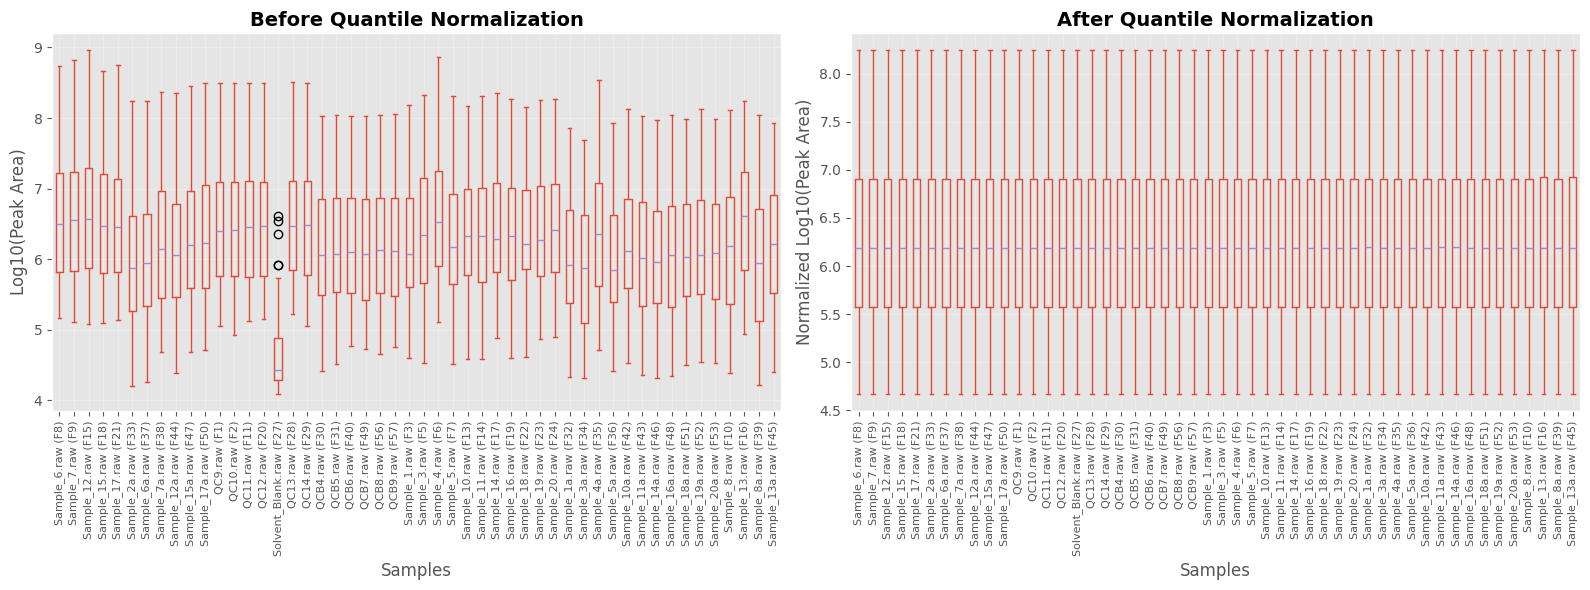


📊 Normalization Effect:
Before: Mean CV across samples = 14.21%
After:  Mean CV across samples = 14.11%


In [8]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before normalization
selection.plot(kind='box', ax=axes[0])
axes[0].set_title('Before Quantile Normalization', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Samples', fontsize=12)
axes[0].set_ylabel('Log10(Peak Area)', fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=8)
axes[0].grid(True, alpha=0.3)

# After normalization
selection_norm.plot(kind='box', ax=axes[1])
axes[1].set_title('After Quantile Normalization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Samples', fontsize=12)
axes[1].set_ylabel('Normalized Log10(Peak Area)', fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Normalization Effect:")
print(f"Before: Mean CV across samples = {(selection.std()/selection.mean()).mean()*100:.2f}%")
print(f"After:  Mean CV across samples = {(selection_norm.std()/selection_norm.mean()).mean()*100:.2f}%")

## 8. Export Normalized Data

Save the quantile-normalized peak areas for downstream analysis or archival purposes.

In [9]:
# Export normalized data
selection_norm.to_csv('Peak_areas_quantile_norm.csv')
print("✓ Normalized data exported to: Peak_areas_quantile_norm.csv")

✓ Normalized data exported to: Peak_areas_quantile_norm.csv


## 9. Load Sample Metadata

### Sample Classification

The metadata file contains sample annotations:
- **NAME**: Original sample filename from LC-MS acquisition
- **rename**: Simplified sample identifier
- **Color**: Color code for visualization
- **CLASS**: Sample classification

### Classification Groups

- **Red (Cytb)**: Cytochrome b inhibitors
- **Blue (Non-cytb)**: Non-cytochrome b inhibitors (various other targets)
- **Brown (Other OxPhos)**: Other oxidative phosphorylation inhibitors
- **Black (QC)**: Quality control pooled samples
- **White (SB)**: Solvent blank control

In [10]:
# Load sample information
sample_info = pd.read_csv('sample_info.txt', sep='\t')

print(f"Sample information loaded: {sample_info.shape[0]} samples")
print(f"\nSample classes: {sample_info['CLASS'].unique().tolist()}")
print(f"\nClass distribution:")
print(sample_info['CLASS'].value_counts())

sample_info.head()

Sample information loaded: 51 samples

Sample classes: ['Non-cytb', 'Cytb', 'Other OxPhos', 'QC', 'SB']

Class distribution:
CLASS
Non-cytb        22
Cytb            12
QC              12
Other OxPhos     4
SB               1
Name: count, dtype: int64


,NAME,rename,Color,CLASS
0,Sample_1.raw (F3),18a,blue,Non-cytb
1,Sample_1a.raw (F32),18b,blue,Non-cytb
2,Sample_2.raw (F4),2a,red,Cytb
3,Sample_2a.raw (F33),2b,red,Cytb
4,Sample_3.raw (F5),12a,blue,Non-cytb


## 10. Create Sample Annotation Dictionaries

Generate lookup dictionaries to map between sample names, colors, and classes for visualization.

In [11]:
# Create mapping dictionaries
sample_groups = sample_info.set_index('rename')['Color'].to_dict()
color_dictionary = sample_info.set_index('Color')['CLASS'].to_dict()
rename_dict = sample_info.set_index('NAME')['rename'].to_dict()

print("Sample annotation dictionaries created:")
print(f"  - sample_groups: {len(sample_groups)} entries (sample -> color)")
print(f"  - color_dictionary: {len(color_dictionary)} entries (color -> class)")
print(f"  - rename_dict: {len(rename_dict)} entries (original name -> simplified name)")

print("\nColor to Class mapping:")
for color, class_name in color_dictionary.items():
    print(f"  {color}: {class_name}")

Sample annotation dictionaries created:
  - sample_groups: 40 entries (sample -> color)
  - color_dictionary: 5 entries (color -> class)
  - rename_dict: 51 entries (original name -> simplified name)

Color to Class mapping:
  blue: Non-cytb
  red: Cytb
  brown: Other OxPhos
  black: QC
  white: SB


## 11. Metabolite Feature Summary

Display the metabolite features included in the analysis. These represent the cytochrome b signature metabolites identified in the original study.

In [12]:
print(f"Total metabolite features: {len(selection_norm.index.values)}\n")
print("Metabolite identifiers:")
for i, feature in enumerate(selection_norm.index.values, 1):
    print(f"  {i:2d}. {feature}")

Total metabolite features: 46

Metabolite identifiers:
   1. C12H23NO4_Isovalerylcarnitine_0.26
   2. C9H11NO2_Phenylalanine_0.5
   3. C4H7N3O_Creatinine_-1.64
   4. C3H7NO2_D-(-)-Alanine_-1.99
   5. C10H16N2O3S_Biotin_0.17
   6. C8H6_[Similar to: Phenylethanolamine; ?Mass: -35.0372 Da]_-1.25
   7. C8H9N_nan_-1.01
   8. C11H12N2O2_DL-Tryptophan_-0.92
   9. C11H9NO2_trans-3-Indoleacrylic acid_-0.88
  10. C5H9N2OPS_nan_0.16
  11. C18H37NO2_Threo-sphingosine, (-)-_0.43
  12. C4H8N2O3_L-(-)-Asparagine_-0.09
  13. C4H8NOPS_nan_0.94
  14. C12H16N4OS_Thiamine_-0.17
  15. C4H9NO3_Homoserine_-1.31
  16. C6H15N4O5P_Phosphoarginine_0.39
  17. C17H27N3O17P2_UDP-GlcNAc_2.29
  18. C7H12N3O7PS_nan_-1.68
  19. C4H7NO4_Aspartate_-0.06
  20. C9H12N2O2_(4-Ethoxyphenyl)urea_-0.64
  21. C14H27NO4_nan_0.69
  22. C5H7N8OPS_nan_1.27
  23. C13H9ClN2O3_2-Chloro-5-nitrobenzanilide_2.9
  24. C5H7O2PS_nan_0.4
  25. C2H5Hg_Ethyl mercury ion_-1.41
  26. C10H11ClNO13P_nan_2.74
  27. C6H16N5O9P3_nan_-1.03
  28. C8H14N

## 12. Dimensionality Reduction Dashboard

### Overview

This comprehensive dashboard applies multiple dimensionality reduction techniques to visualize metabolite patterns:
- **PCA (Principal Component Analysis)**: Linear dimensionality reduction
- **MDS**: Multidimensional Scaling

The dashboard shows both:
1. **Sample space**: How samples cluster based on their metabolite profiles
2. **Feature space**: How metabolites contribute to the separation (loadings)

### Parameters

- **top=500**: Use all available metabolite features
- Solvent blank is excluded from analysis

Explained variance ratio: [0.56098911 0.12367838 0.08273994 0.07455843 0.03114496]


/opt/venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


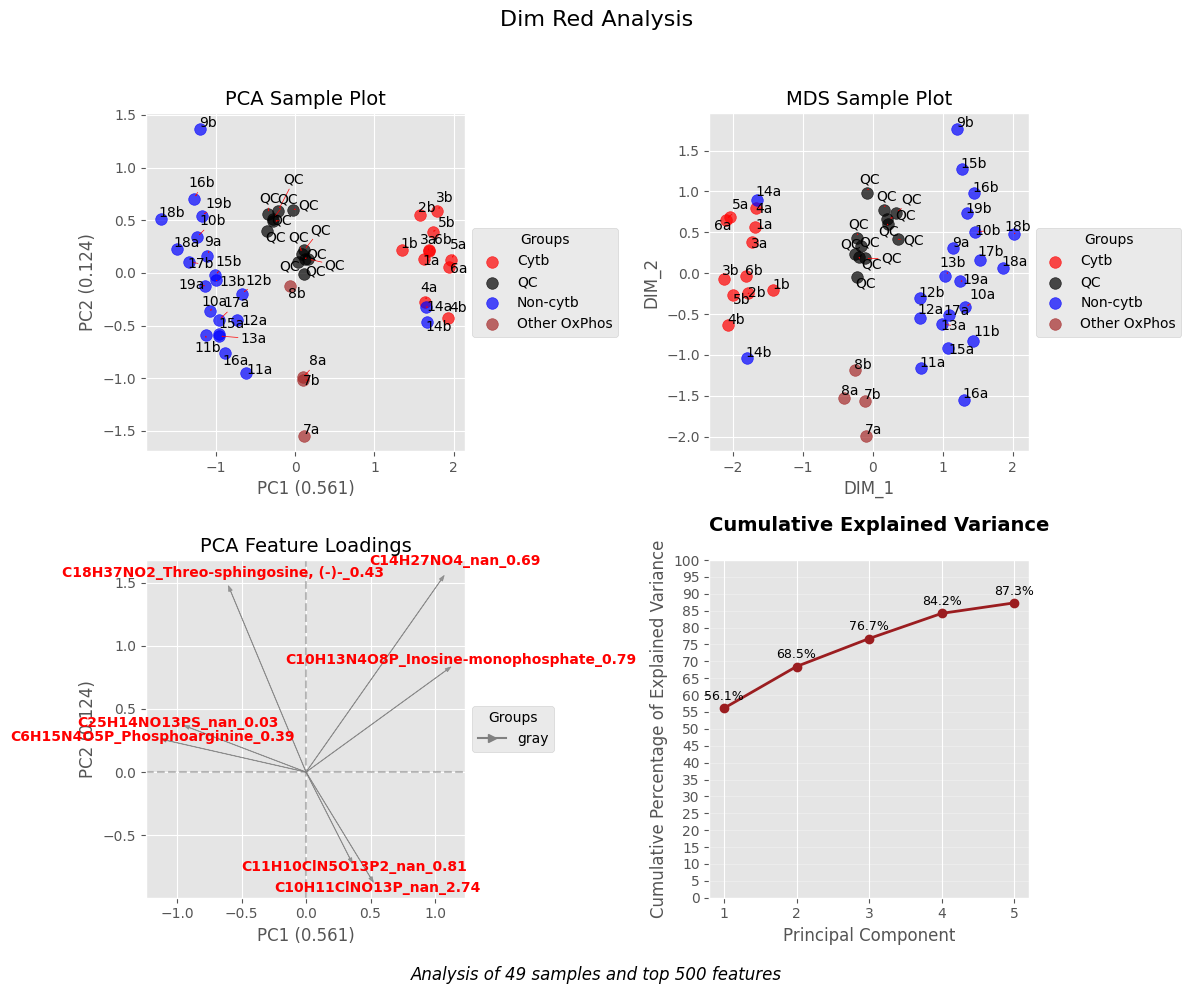

In [13]:
# Create comprehensive dimensionality reduction dashboard
fig, axes, results_dict = dim_red_utility.create_dim_reduction_dashboard(
    in_df=selection_norm.drop(['Solvent_Blank.raw (F27)'], axis=1).rename(rename_dict, axis=1),
    sample_palette=sample_groups,
    feature_palette={},
    top=500,
    color_dictionary=color_dictionary,
    title="Dim Red Analysis",
    figsize=(12, 10)  
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 13. Principal Component Analysis (PCA)

### Reproducing Figure 3 from the Manuscript

This PCA plot validates the cytochrome b metabolomic signature by demonstrating clear separation between:
- **Cytochrome b inhibitors** (red): Cluster together, indicating a common metabolic signature
- **Non-cytochrome b inhibitors** (blue): Separate cluster with diverse mechanisms of action
- **Other OxPhos inhibitors** (brown): Distinct intermediate position (oligomycin A, DNP)
- **QC samples** (black): Technical replicates showing method reproducibility

### Key Observations

1. Clear separation validates the metabolomic approach for triaging cytochrome b inhibitors
2. Other oxidative phosphorylation inhibitors cluster separately from cytochrome b inhibitors
3. QC samples show good clustering, indicating technical reproducibility
4. Biological replicates (a and b) cluster closely together

### Parameters

- **top=5000**: Use all available features (we only have 46 metabolites)
- **n_components=2**: Project to 2D for visualization
- **do_adjust_text=True**: Automatically adjust label positions to avoid overlap

Explained variance ratio: [0.56098911 0.12367838]


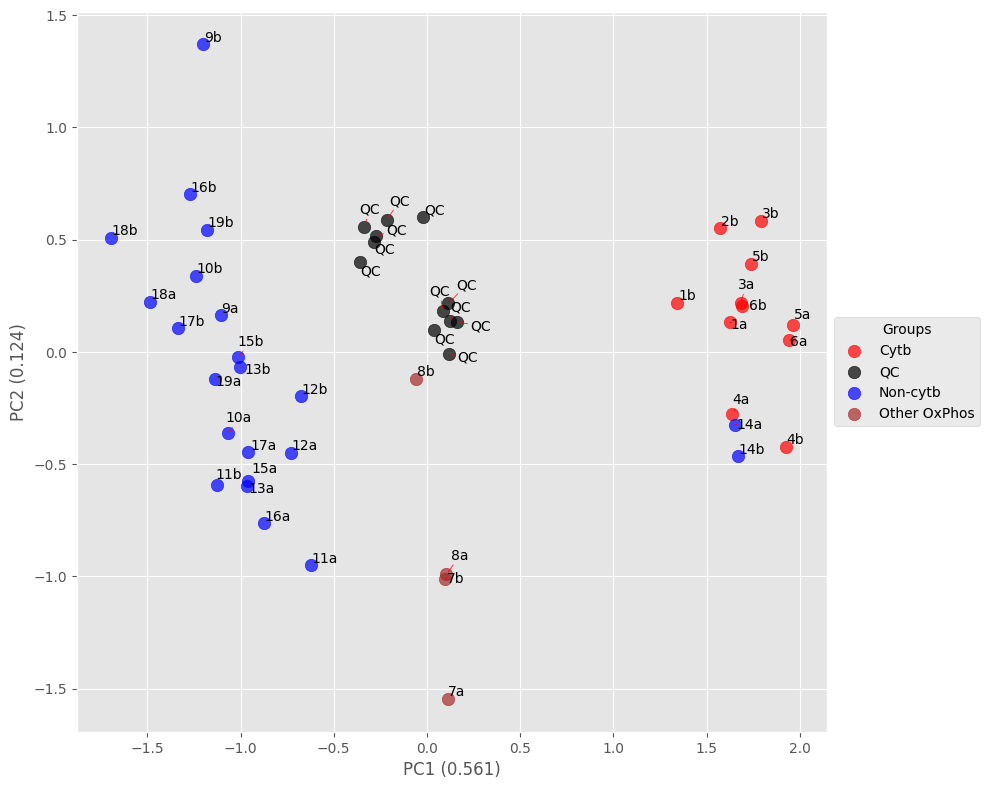

✓ PCA plot saved to: PCA.svg


In [14]:
# Create a plotter instance
plotter = dim_red_utility.DimensionalityReductionPlotter(
    in_df=selection_norm.drop(['Solvent_Blank.raw (F27)'], axis=1).rename(rename_dict, axis=1),
    top=5000,
    color_dictionary=color_dictionary
)

# Fit PCA and plot samples
plotter.fit(method='pca', n_components=2)
fig, ax, tmp_df = plotter.plot_samples(
    palette=sample_groups,
    point_size=80,
    do_adjust_text=True,
    title=""
)

plt.tight_layout()
plt.savefig('PCA.svg')
plt.show()

print("✓ PCA plot saved to: PCA.svg")

## 14. PCA Loading Analysis

### Interpretation
The loading plot shows which metabolite features contribute most to the separation observed in the PCA scores plot:
- **Arrow length**: Indicates the strength of contribution to PC1 and PC2
- **Arrow direction**: Shows which samples have higher/lower levels of that metabolite

### Parameters
- **arrow=True**: Display loadings as arrows (biplot style)
- **arrow_scale=3**: Scale factor for arrow length
- **biggest=3**: Extract the top 3 metabolites with strongest contributions from 1st and 2d components

These metabolites represent the most discriminative features of the cytochrome b signature.

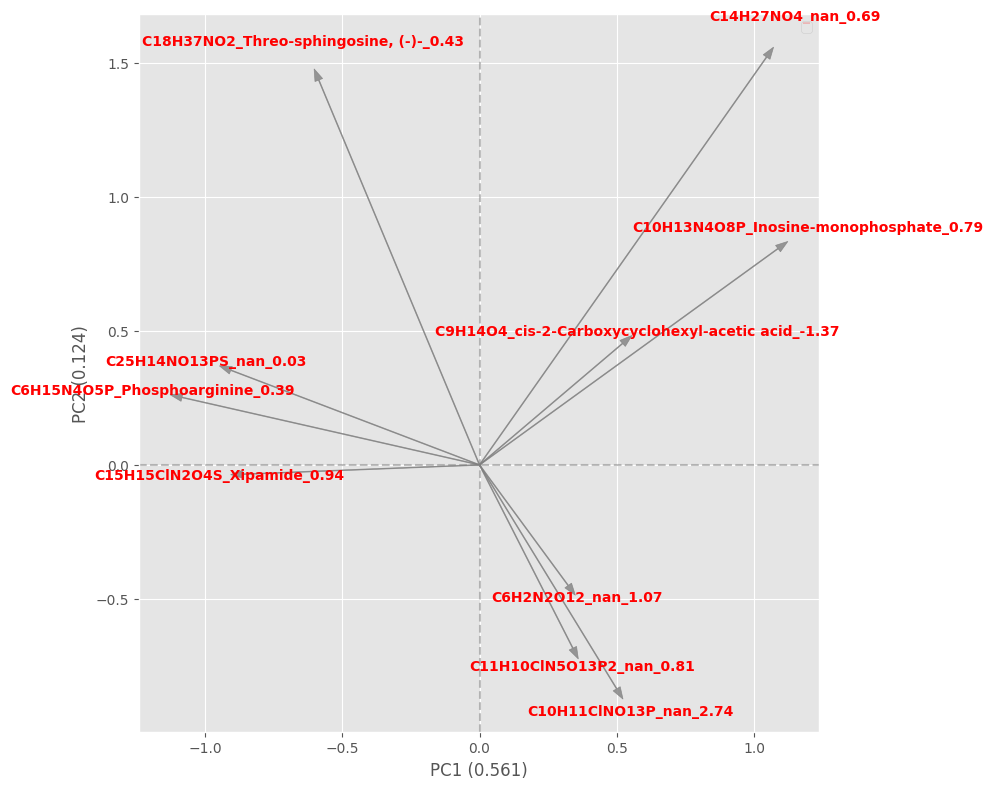

✓ Loading plot saved to: Loading.svg


In [15]:
# Plot PCA loadings
fig, ax, tmp_df = plotter.plot_loadings(
    palette={},
    arrow=True,
    arrow_scale=3,
    title="",
    biggest=3
)

ax.legend('')
plt.tight_layout()
plt.savefig('Loading.svg')
plt.show()
print("✓ Loading plot saved to: Loading.svg")

## 15. Summary and Conclusions

### Key Findings

This analysis successfully reproduces the validation of the cytochrome b metabolomic signature:

1. **Clear separation**: PCA demonstrates distinct clustering of cytochrome b inhibitors from other compound classes

2. **Technical reproducibility**: QC samples and biological replicates cluster tightly, validating the method

3. **Mechanistic specificity**: Other oxidative phosphorylation inhibitors (oligomycin A, DNP) cluster separately, showing the signature is specific to cytochrome b inhibition

4. **Practical utility**: This approach enables rapid triaging of cytochrome b inhibitors during Chagas' disease drug discovery

### Workflow Summary

```
LC-MS Peak Areas
       ↓
Log10 Transformation
       ↓
Quantile Normalization
       ↓
Principal Component Analysis
       ↓
Classification & Triage
```

### Output Files Generated

- `Peak_areas_quantile_norm.csv`: Normalized metabolite data
- `PCA.svg`: Principal component analysis scores plot
- `Loading.svg`: PCA loading plot showing key metabolites

---

**Analysis Complete** ✓